# Queueing Theory

an empirical approach

by Heinrich Hartmann,

SREConEurope 2017


# Introduction

A queueing system consists of a queue and a number of servers.
Customers arrive at the queue and wait until the server is ready to service the customer.
After the customer has been served he leaves the system.

A queueing system, might contain multiple queues and multiple servers.
In more complex scenario, multiple queues are present, and requests are routed between them.

## Kendals notation


Queuing systems are rougly classified by the following three parameters

`A/B/m`

where

* `A` arrival process (e.g. Poisson (M), General(G))
* `B` service time distribution (e.g. Exponential(M), Deterministic(D), General (G))
* `m` number of servers

We will be mainly concerned with `M/D/1` and `M/M/1` queues.

Reference: https://en.wikipedia.org/wiki/Kendall%27s_notation

## Examples of Queueing systems

1. A web server (Apache vs. Node)

1. CPU run queue (multiple CPUs)

1. Request queue for disk

1. Network buffers

1. Waiting lines at the super-market

## Basic Questions

1. How long do customers have to wait to be serviced? (API performance)

1. How much more load can the server take?

1. How much do additional servers decrease the wait time?

# Terminology

## Request View

Each customer $c$ runs throught the following states:

* (I) initial state (pre-arrival)
* (Q) Waiting in Queue
* (S) Service in progress
* (D) Departed (terminal state)

The service transition times are denoted by:

* the arrival time
* the service time
* the departure time

And the state durations are

* the residence duration, or total waiting duration $W(c)$
* the waiting in queue duration $W_q(c)$
* the service duration $S(c)$

So that:

$$ W(c) = W_q(c) + S(c) $$

### Customer Averages

Order the customers by time of arrival $c=1,2,\dots$, then

$$ W = \lim_{N \rightarrow \infty} \frac{1}{N} \sum_{c=1}^N W(c) $$

$$ W_q = \lim_{N \rightarrow \infty} \frac{1}{N} \sum_{c=1}^N W_q(c) $$

$$ S = \lim_{N \rightarrow \infty} \frac{1}{N} \sum_{c=1}^N S(c) $$


## System View

### Arrival Pattern

There are two possible scenarios we will consider:

(a) The arrivals are given to us as input data, e.g. from log files
(b) The arrivals are simulated

In the second case, where we simulated, we will assume that the generating process has nice properties.
More precisely we will assume that the arrivals have nice mathematical properties (Stationary, Ergodic, Poisson process)

Notation:

* Arrival function $$N(t) = \# \{ \text{ customers that arrived before time $t$ } \} = N([0,t))$$

In analogy we can also consider:

* Servicing function $$N_S(t) = \# \{ \text{ customers that started service before time $t$ } \} $$
* Departure function $$M(t) = \# \{ \text{ customers that depated before time $t$ } \} $$

> image

### Arrival Rate

The arrival rate $\lambda$ is the average number of requests that are arriving at the system.
It can be defined as:

$$ \lambda = \lim_{t\rightarrow \infty} \frac{N(t)}{t} $$

### Queue length

From the perspective of the system we have:

* The concurrency $$L(t) = \# \{ \text{ customers inside the system at time $t$} \}$$

* The queue length $$L_q(t) = \# \{ \text{ customers waiting in the queue at time $t$} \}$$

* The service length $$L_s(t) = \# \{ \text{ customers being served at time $t$ } \}$$

> image

### Utilization

Note that $L_s(t) \leq \text{(number of servers)}$. $L_s(t) > 0$ whenever the system is busy.
The integral average of $L_s(t)$ over a time interval $I=[t_1, t_2]$ is called utilization:

$$ \rho(I) = \frac{\int_{t_1}^{t_2} L_s(t) dt}{t_2 - t_1}. $$

In monitoring applications we are often interested in the utilization across intervals of 1 minute.
To get a precise estimate, consider the following function:

$$ Util(T) = \int_0^T L_s(t) dt $$

The utilization can be calculated as discrete derivative:

$$ \rho(I) = \frac{Util(t_2) - Util(t_1)}{t_2 - t_1} $$

It turns out that this function can be tracked efficiently within an application, since:

$$Util(T+\Delta T) = Util(T) + L_s(T) \Delta T $$

if $L_s(t)$ is constant within $T, T+\Delta T$. Hence, $Util(T)$ can be tracked by incrementing
$L_s(T) \Delta T$ eacht time a new customer is served. The average utilization can then
be derived as $\rho(I) = Util(t_2) - Util(t_1).$

The same reasoning can be applied to the average queue length. This method is used by the Linux
kernel to track average queue sizes for disks: https://www.circonus.com/2017/07/monitoring-queue-sizes/

### Average Queue Sizes

Similarly the average queue length over a time interavel $I=[t_1, t_2]$ is defined as

$$ L_q(I) = \frac{\int_{t_1}^{t_2} L_q(t) dt}{t_2 - t_1}. $$


### Time Averages

We can look at the following time Averages

* Average concurrency $$ L = \lim_{T \rightarrow \infty} \frac{1}{T} \int_0^T L(t) dt $$
* Average  queue length $$ L_q = \lim_{T \rightarrow \infty} \frac{1}{T} \int_0^T L_q(t) dt $$
* Average utilization $$ L_s = \lim_{T \rightarrow \infty} \frac{1}{T} \int_0^T L_s(t) dt $$

There are two interpretations of these limits possibe. In practice, we hava finite dataset so the
limit is just finite. In theory, we generate our requests by a probabilistic process, which we
assume to be stationary and ergodic so the above limits exists and are finite.


# Little's Law

Little proved in 1960 some fundamental relations between the time averages and the customer averages

1. $ L   = \lambda \cdot W   $
1. $ L_q = \lambda \cdot W_q $
1. $ \rho = L_s = \lambda \cdot S $


> Drawing, graphical explanation

# Expected Waiting time

Consider an M/D/1 queue, with arrival rate $\lambda$ and constant service time $S$.

Q: What is the average time $W_q$ a customer has to wait in the queue?

We assume $\rho = \lambda \cdot S < 1$, since otherwise the load can't be served, and the system is not stable.
The expected number of customers in the queue at arrival is $L_q$ (PASTA property of Poisson
Process) Hence, the expected wait time, caused by customers in the queue is $L_q \cdot S$.  In
addition we have to consider the wait time caused by the customer that is being serviced, if there
is one, so:

$$ W_q = L_q S + P[\text{server busy}] E[\text{residual service time}|\text{server busy}]$$

Now, $P[\text{server busy}] = \rho$ by PASTA. Moreover, if the server is busy we are in the middle
of service duration of length $S$, and we expect a residual service time of $S/2$, so:

$$ W_q = L_q S + \rho \cdot S/2 $$

Substituting Little's formula $L_q = \lambda W_q$ for $L_q$, and solving for $W_q$ we find:

$$ W_q = \frac{1}{2} \frac{\rho}{1-\rho} S $$

Further reading:

* Pollaczek-Khinchine Formula https://en.wikipedia.org/wiki/Pollaczek–Khinchine_formula
* https://en.wikipedia.org/wiki/M/D/1_queue

Variants:

The expected wait time depends on the service time distribution. E.g. in the M/M/1 case, with
exponential service distribution has:

$$ W_q = \frac{\rho}{1-\rho} S $$

Precisely doubleing the expected wait time.

In general Variance in the service time causes higher expected wait times.


In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

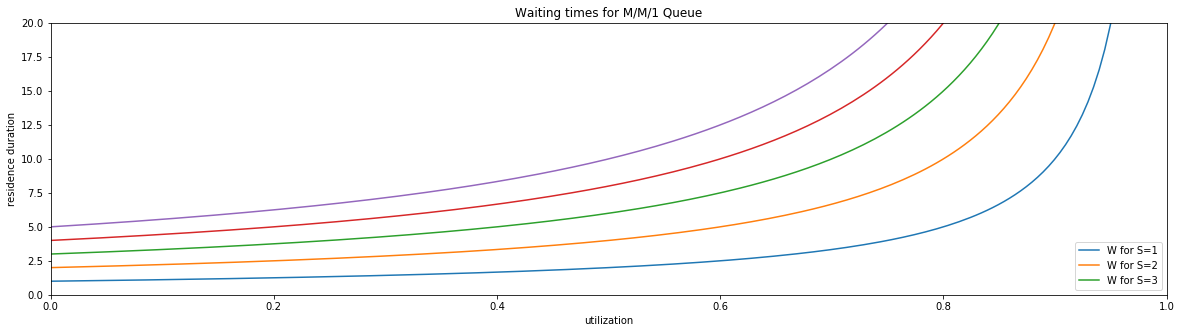

In [46]:
def plot_Wq(S):
    X=np.linspace(0, 0.9999,200)
    Y=[ S + S * x/(1-x)  for x in X ]
    plt.plot(X,Y)


plt.figure(figsize=(20,5))
plot_Wq(1)
plot_Wq(2)
plot_Wq(3)
plot_Wq(4)
plot_Wq(5)
plt.legend(["W for S=1","W for S=2","W for S=3"])
plt.ylim(0,20)
plt.xlim(0,1)
plt.title("Waiting times for M/M/1 Queue")
plt.ylabel("residence duration")
plt.xlabel("utilization")

# Scalability

The maximal throughtput of a M/G/1 queue is $1/E[S] = \mu$, the service rate.
When we want to serve more incoming requests at a sensible residence time we have to add capacity to the queing system.

There are three main ways to do that:

- (A) Reduce the service time: $S \rightarrow S/m$ (if this is possible)
- (B) Add more queues $(M/G/1)\times m$
- (C) Add more servers $M/G/m$

In all three cases the maximal throughput $X$ is $m \times \mu$, i.e. we have *linear scalability*.
The differences lie in the average residence durations:

* Replacing $S$ by $S/m$ we find:

  $$ W_A = \frac{1}{m\mu - \lambda} $$

* Each queue is serving a fraction of the load, so we can replace $\lambda$ by $\lambda/m$ to get:

  $$ W_B = \frac{1}{\mu - \lambda/m} = \frac{m}{m \mu - \lambda} = m W_A $$

* The derivation of this is due to Erlang in 1907 and involves horrendous formulas. We just give an approximation here:

  $$ W_C \approx \frac{S}{1 - \rho^m} = \frac{1}{\mu} \frac{(m \mu)^m}{(m \mu)^m - \lambda^m} $$

How do these compare to each other?

In [30]:
import warnings
warnings.filterwarnings('ignore')

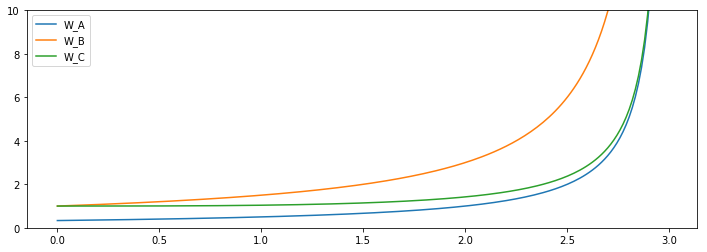

In [32]:
#
# A numerical comparison
#
m = 3
mu = 1
X = np.linspace(0,m, 200)
W_A = (m*mu - X) ** -1
W_B = m * W_A
mmm = (m * mu)**m
W_C = 1/mu * mmm / (mmm - X ** m)

plt.figure(figsize=(4*m, 4))
plt.plot(X, W_A)
plt.plot(X, W_B)
plt.plot(X, W_C)
plt.ylim(0,10)
plt.legend(["W_A","W_B","W_C"])


Interactive Version: https://www.desmos.com/calculator/qpbnllcyeo

# Scalability Laws

In paractice we will seldom achieve linear scalability, since our workload is not fully paralelizable.
If there is a fraction $\sigma$ of the workload that needs to be done serially, then the maximal speedup we can expect is:

$$  X(m, \sigma) = \mu \frac{m}{1 + \sigma (m - 1)}$$

This result is known as *Ahmdals Law*.

In addition to the serial fraction, most systems require a certain amount of *crosstalk* $\kappa$ between the
nodes, in order to function, in this case the throughput can even degrade with increasing concurrency $m$:

$$ X(m, \sigma, \kappa) = \mu \frac{m}{1 + \sigma(m-1) + \kappa m(m-1)} $$

This result is known as the *Universal Scalability Law*.

Explore: https://www.desmos.com/calculator/pntup6jbhw